In [1]:
from one.api import ONE
from brainbox.io.one import load_channel_locations 
import brainbox.behavior.wheel as wh
from brainbox.processing import bincount2D
from ibllib.atlas import regions_from_allen_csv
import ibllib.atlas as atlas
from ibllib.atlas import AllenAtlas
from ibllib.atlas.regions import BrainRegions
from brainbox.io.one import SpikeSortingLoader
import numpy as np
from pathlib import Path
from collections import Counter
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, spearmanr
from copy import deepcopy
import pandas as pd
import random
import seaborn as sns
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from scipy.stats import zscore
import itertools
from mpl_toolkits.mplot3d import Axes3D
import os, sys
from scipy.interpolate import interp1d
import matplotlib
from scipy import stats
from scipy.stats import percentileofscore
matplotlib.rcParams.update({'font.size': 10})


In [2]:
# now we use decoding function from the decoding pipeline, with and without motor signals to see if there is any differences

import pandas as pd
import sys
from braindelphi.decoding.settings import kwargs, N_PSEUDO_PER_JOB, N_PSEUDO
# from braindelphi.decoding.functions.decoding import fit_eid
import numpy as np
from braindelphi.params import CACHE_PATH, IMPOSTER_SESSION_PATH
from braindelphi.decoding.functions.utils import load_metadata
import pickle

from behavior_models.models.utils import format_data as format_data_mut

kwargs['motor_regressors'] = False
print(kwargs)


File "/home/users/h/hubertf/.conda/envs/iblenv/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
File "/home/users/h/hubertf/.conda/envs/iblenv/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
File "/home/users/h/hubertf/.conda/envs/iblenv/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
File "/home/users/h/hubertf/.conda/envs/iblenv/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
File "/home/users/h/hubertf/.conda/envs/iblenv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
    self.io_loop.start()
File "/home/users/h/hubertf/.conda/envs/iblenv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
File "/home/users/h/hubertf/.conda/envs/iblenv/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
    sel

/home/users/h/hubertf/.conda/envs/iblenv/lib/python3.9/site-packages/ibllib/dsp/__init__.py:7: DeprecationWarning: ibllib.dsp is deprecated and functionality will be removed, change your imports to neurodsp ! See stack above
  warnings.warn('ibllib.dsp is deprecated and functionality will be removed'


In [3]:
# import most recent cached data

motor_eids = get_all_sess_with_ME()

bwmdf, _ = load_metadata(CACHE_PATH.joinpath('*_%s_metadata.pkl' % kwargs['neural_dtype']).as_posix())
eids = bwmdf['dataset_filenames']['eid'].values
print(len(eids))
for eid in eids :
     if eid not in motor_eids : 
          print(eid)

NameError: name 'get_all_sess_with_ME' is not defined

In [4]:

# we want to get the weights out here too

def format_results(finished):
    indexers = ['subject', 'eid', 'probe', 'region']
    indexers_neurometric = ['low_slope', 'high_slope', 'low_range', 'high_range', 'shift', 'mean_range', 'mean_slope']
    resultslist = []
    failed_load = 0
    for fn in finished:
        try:
            fo = open(fn, 'rb')
            result = pickle.load(fo)
            fo.close()
            if result['fit'] is None:
                continue
            for i_run in range(len(result['fit'])):
                side, stim, act, _ = format_data_mut(result["fit"][i_run]["df"])
                mask = result["fit"][i_run]["mask"]  # np.all(result["fit"][i_run]["target"] == stim[mask])
                tmpdict = {**{x: result[x] for x in indexers},
                        'fold': -1,
                        'pseudo_id': result['pseudo_id'],
                        'N_units': result['N_units'],
                        'run_id': i_run + 1,
                        'mask': ''.join([str(item) for item in list(result['fit'][i_run]['mask'].values * 1)]),
                        'R2_test': result['fit'][i_run]['Rsquared_test_full'],
                        'prediction': list(result["fit"][i_run]['predictions_test']),
                        'target': list(result["fit"][i_run]["target"]),

                        'weights': np.vstack(result['fit'][i_run]['weights']) # so we can directly look at the weights

                        }
                if 'acc_test_full' in result['fit'][i_run].keys():
                    tmpdict = {**tmpdict, 'acc_test': result['fit'][i_run]['acc_test_full'],
                            'balanced_acc_test': result['fit'][i_run]['balanced_acc_test_full']}
                if result['fit'][i_run]['full_neurometric'] is not None:
                    tmpdict = {**tmpdict,
                            **{idx_neuro: result['fit'][i_run]['full_neurometric'][idx_neuro]
                                for idx_neuro in indexers_neurometric}}
                resultslist.append(tmpdict)
        except EOFError:
            failed_load += 1
            pass
    print('loading of %i files failed' % failed_load)
    resultsdf = pd.DataFrame(resultslist)
    return resultsdf


In [ ]:
# run decoding for one session / USING MOTOR REGRESSORS
kwargs['motor_regressors'] = True
# import most recent cached data
bwmdf, _ = load_metadata(CACHE_PATH.joinpath('*_%s_metadata.pkl' % kwargs['neural_dtype']).as_posix())
kwargs['imposterdf'] = None # use_imposter_sessions = False
pid = bwmdf['dataset_filenames'].iloc[0] # we take the first session
metadata = pickle.load(open(pid.meta_file, 'rb'))
regressors = pickle.load(open(pid.reg_file, 'rb'))
trials_df, neural_dict = regressors['trials_df'], regressors #ephyse only, there's no motor signals corresponding to wfi data
pseudo_ids = [1] # we only simulate one pseudo-session to test
results_fit_eid_motor = fit_eid(neural_dict=neural_dict, trials_df=trials_df, metadata=metadata,
                            pseudo_ids=pseudo_ids, **kwargs)


In [6]:
results_df_motor = format_results(results_fit_eid_motor)

loading of 0 files failed


In [12]:
# run decoding for one session / NO MOTOR REGRESSORS
kwargs['motor_regressors'] = False
# import most recent cached data
bwmdf, _ = load_metadata(CACHE_PATH.joinpath('*_%s_metadata.pkl' % kwargs['neural_dtype']).as_posix())
kwargs['imposterdf'] = None # use_imposter_sessions = False
pid = bwmdf['dataset_filenames'].iloc[0] # we take the first session
metadata = pickle.load(open(pid.meta_file, 'rb'))
regressors = pickle.load(open(pid.reg_file, 'rb'))
trials_df, neural_dict = regressors['trials_df'], regressors #ephyse only, there's no motor signals corresponding to wfi data
pseudo_ids = [1] # we only simulate one pseudo-session to test
results_fit_eid_no_motor = fit_eid(neural_dict=neural_dict, trials_df=trials_df, metadata=metadata,
                            pseudo_ids=pseudo_ids, **kwargs)
results_df_no_motor = format_results(results_fit_eid_no_motor)

Working on eid : 56956777-dca5-468c-87cb-78150432cc57


Region:   0%|          | 0/1 [00:00<?, ?it/s]/home/users/h/hubertf/.conda/envs/iblenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.604e-03, tolerance: 1.104e-03
  model = cd_fast.enet_coordinate_descent(
/home/users/h/hubertf/.conda/envs/iblenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.944e-03, tolerance: 1.071e-03
  model = cd_fast.enet_coordinate_descent(
/home/users/h/hubertf/.conda/envs/iblenv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the nu

loading of 0 files failed


In [32]:
weights_no_motor = np.mean(results_df_no_motor['weights'][0],axis=0)
weights_motor = np.mean(results_df_motor['weights'][0],axis=0)[:weights_no_motor.shape[0]]
weights_motor_reg = np.mean(results_df_motor['weights'][0],axis=0)[weights_no_motor.shape[0]:]

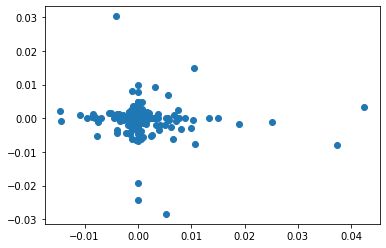

In [33]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(weights_no_motor,weights_motor)
plt.show()

In [34]:
results_df_motor

,subject,eid,probe,region,fold,pseudo_id,N_units,run_id,mask,R2_test,prediction,target,weights
0,NYU-11,56956777-dca5-468c-87cb-78150432cc57,merged_probes,"[BMA, CA1, CA2, CA3, CEA, COAp, GPe, IA, LGd, ...",-1,1,379,1,0000000000000000000000000000000000000000000000...,0.295374,"[[0.2751928527077465], [0.4901620018282066], [...","[[0.7756636], [0.6184148], [0.4544139], [0.321...","[[0.0, -0.0034293864939877144, 0.0, 0.02117567..."


In [35]:
results_df_no_motor

,subject,eid,probe,region,fold,pseudo_id,N_units,run_id,mask,R2_test,prediction,target,weights
0,NYU-11,56956777-dca5-468c-87cb-78150432cc57,merged_probes,"[BMA, CA1, CA2, CA3, CEA, COAp, GPe, IA, LGd, ...",-1,1,379,1,0000000000000000000000000000000000000000000000...,0.361583,"[[0.31266242895945695], [0.5084390953052507], ...","[[0.44378072], [0.6409229], [0.70236015], [0.7...","[[-0.0, -0.0, 0.0, -0.0, 0.0, -0.0041313271522..."


In [5]:


one = ONE()
ba = AllenAtlas()
br = BrainRegions()
T_BIN = 0.02
Fs = {'left':60,'right':150, 'body':30}

# specify binning type, either bins or sampling rate; see cut_gahavior for defs
sr_michael = {'licking':'T_BIN','whisking_l':60, 'whisking_r':150, 
      'wheeling':'T_BIN','nose_pos':60, 'paw_pos_r':150, 
      'paw_pos_l':60}
sr = {'licking':'T_BIN','whisking_l':'T_BIN', 'whisking_r':'T_BIN', 
      'wheeling':'T_BIN','nose_pos':'T_BIN', 'paw_pos_r':'T_BIN', 
      'paw_pos_l':'T_BIN'}

# Hi Michael ! I hope you're having a fantastic summer ! A little question about your movement code : why did you

blue_left = [0.13850039, 0.41331206, 0.74052025]
red_right = [0.66080672, 0.21526712, 0.23069468]
cdi = {0.8:blue_left,0.2:red_right,0.5:'g',-1:'cyan',1:'orange'}
def blockPrint():
    sys.stdout = open(os.devnull, 'w')
# Restore
def enablePrint():
    sys.stdout = sys.__stdout__
    
def get_all_sess_with_ME():
    one = ONE()
    # get all bwm sessions with dlc
    all_sess = one.alyx.rest('sessions', 'list', 
                              project='ibl_neuropixel_brainwide_01',
                              task_protocol="ephys", 
                              dataset_types='camera.ROIMotionEnergy')
    eids = [s['url'].split('/')[-1] for s in all_sess]
    
    return eids  

def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx
 
def get_licks(XYs):
    '''
    define a frame as a lick frame if
    x or y for left or right tongue point
    change more than half the sdt of the diff
    '''  
    
    licks = []
    for point in ['tongue_end_l', 'tongue_end_r']:
        for c in XYs[point]:
           thr = np.nanstd(np.diff(c))/4
           licks.append(set(np.where(abs(np.diff(c))>thr)[0]))
    return sorted(list(set.union(*licks))) 
            
def get_ME(eid, video_type, query_type='remote'): # 'auto' instead of 'remote' or "local" for the better
    #video_type = 'left'           
    Times = one.load_dataset(eid,f'alf/_ibl_{video_type}Camera.times.npy',
                             query_type=query_type) 
    ME = one.load_dataset(eid,f'alf/{video_type}Camera.ROIMotionEnergy.npy', 
                          query_type=query_type)
    return Times, ME  

def get_dlc_XYs(eid, video_type, query_type='remote'):
    #video_type = 'left'    
    Times = one.load_dataset(eid,f'alf/_ibl_{video_type}Camera.times.npy',
                             query_type=query_type) 
    cam = one.load_dataset(eid,f'alf/_ibl_{video_type}Camera.dlc.pqt', 
                           query_type=query_type)
    points = np.unique(['_'.join(x.split('_')[:-1]) for x in cam.keys()])
    # Set values to nan if likelyhood is too low # for pqt: .to_numpy()
    XYs = {}
    for point in points:
        x = np.ma.masked_where(
            cam[point + '_likelihood'] < 0.9, cam[point + '_x'])
        x = x.filled(np.nan)
        y = np.ma.masked_where(
            cam[point + '_likelihood'] < 0.9, cam[point + '_y'])
        y = y.filled(np.nan)
        XYs[point] = np.array(
            [x, y])    
    return Times, XYs    

def cut_behavior(eid, duration =0.4, lag = -0.6, 
                 align='stimOn_times', stim_to_stim=False, 
                 endTrial=False, query_type='remote',pawex=False):
    '''
    cut segments of behavioral time series for PSTHs
    
    param: eid: session eid
    param: align: in stimOn_times, firstMovement_times, feedback_times    
    param: lag: time in sec wrt to align time to start segment
    param: duration: length of cut segment in sec 
    '''
    # get wheel speed    
    wheel = one.load_object(eid, 'wheel', query_type=query_type)
    pos, times_w = wh.interpolate_position(wheel.timestamps,
                                           wheel.position, freq=1/T_BIN)
    v = np.append(np.diff(pos),np.diff(pos)[-1]) 
    v = abs(v) 
    v = v/max(v)  # else the units are very small
    
    # load whisker motion energy, separate for both cams
    times_me_l, whisking_l0 = get_ME(eid, 'left', query_type=query_type)
    times_me_r, whisking_r0 = get_ME(eid, 'right', query_type=query_type)    
    
    times_l, XYs_l = get_dlc_XYs(eid, 'left')
    times_r, XYs_r = get_dlc_XYs(eid, 'right')    
    
    DLC = {'left':[times_l, XYs_l], 'right':[times_r, XYs_r]}
    
    # get licks using both cameras    
    lick_times = []
    for video_type in ['right','left']:
        times, XYs = DLC[video_type]
        r = get_licks(XYs)
        idx = np.where(np.array(r)<len(times))[0][-1]            
        lick_times.append(times[r[:idx]])
    
    lick_times = sorted(np.concatenate(lick_times))
    R, times_lick, _ = bincount2D(lick_times, np.ones(len(lick_times)), T_BIN)
    lcs = R[0]    
    # get paw position, for each cam separate
    
    if pawex:
        paw_pos_r0 = XYs_r['paw_r']
        paw_pos_l0 = XYs_l['paw_r']    
    else:
        paw_pos_r0 = (XYs_r['paw_r'][0]**2 + XYs_r['paw_r'][1]**2)**0.5
        paw_pos_l0 = (XYs_l['paw_r'][0]**2 + XYs_l['paw_r'][1]**2)**0.5
    
    # get nose x position from left cam only
    nose_pos0 = XYs_l['nose_tip'][0]
    licking = []
    whisking_l = []
    whisking_r = []
    wheeling = [] 
    nose_pos = []
    paw_pos_r = []
    paw_pos_l = []
        
    DD = []
           
    pleft = []
    sides = []
    choices = []
    T = [] 
    difs = [] # difference between stim on and last wheel movement
    d = (licking, whisking_l, whisking_r, wheeling,
         nose_pos, paw_pos_r, paw_pos_l,
         pleft, sides, choices, T, difs)
    ds = ('licking','whisking_l', 'whisking_r', 'wheeling',
         'nose_pos', 'paw_pos_r', 'paw_pos_l',
         'pleft', 'sides', 'choices', 'T', 'difs')
         
    D = dict(zip(ds,d))
    
    # continuous time series of behavior and stamps
    behaves = {'licking':[times_lick, lcs],
               'whisking_l':[times_me_l, whisking_l0], 
               'whisking_r':[times_me_r, whisking_r0], 
               'wheeling':[times_w, v],
               'nose_pos':[times_l, nose_pos0],
               'paw_pos_r':[times_r,paw_pos_r0], 
               'paw_pos_l':[times_l,paw_pos_l0]}
    trials = one.load_object(eid, 'trials', query_type=query_type)    
    wheelMoves = one.load_object(eid, 'wheelMoves', query_type=query_type)
    
    print('cutting data')
    trials = one.load_object(eid, 'trials', query_type=query_type)
    evts = ['stimOn_times', 'feedback_times', 'probabilityLeft',
            'choice', 'feedbackType','firstMovement_times']
            
    kk = 0     
    for tr in range(len(trials['intervals'])): 
        
        '''
        # skip trial if any key info is nan 
        if any(np.isnan([trials[k][tr] for k in evts])):
            continue
        
        # skip trial if any key info is nan for subsequ. trial    
        if any(np.isnan([trials[k][tr + 1] for k in evts])):
            continue            

        # skip trial if too long
        if trials['feedback_times'][tr] - trials['stimOn_times'][tr] > 10: 
            continue   
        
        # skip block boundary trials
        if trials['probabilityLeft'][tr] != trials['probabilityLeft'][tr+1]:
            continue
        '''
        
        a = wheelMoves['intervals'][:,1]
        '''
        b = trials['stimOn_times'][tr]
        c = trials['feedback_times'][tr - 1]     
        # making sure the motion onset time is in a coupled interval
        ind = np.where((a < b) & (a > c))[0]
        try:
            a = a[ind][-1]
        except:
            continue   
        
        
        difs.append(b-a)
        '''

        if stim_to_stim:
            start_t = trials['stimOn_times'][tr]    
                    
        elif align == 'wheel_stop':            
            start_t = a + lag    
            
        else:                                
            start_t = trials[align][tr] + lag     
                
        if np.isnan(trials['contrastLeft'][tr]):
            cont = trials['contrastRight'][tr]            
            side = 0  # right side stimulus
        else:   
            cont = trials['contrastLeft'][tr]         
            side = 1  # left side stimulus                   
                  
        sides.append(side) 
        
        if endTrial:
            choices.append(trials['choice'][tr+1])
        else:                              
            choices.append(trials['choice'][tr])   
                 
        pleft.append(trials['probabilityLeft'][tr])
         
        for be in behaves: 
            times = behaves[be][0] 
            series = behaves[be][1] 
            start_idx = find_nearest(times,start_t)        
            if stim_to_stim:  
                end_idx = find_nearest(times, trials['stimOn_times'][tr + 1])
            else:
                if sr[be] == 'T_BIN':
                    end_idx = start_idx + int(duration/T_BIN)
                else:
                    fs = sr[be]
                    end_idx = start_idx + int(duration*fs)              
            
            if (pawex and ('paw' in be)): #for illustration on frame
                D[be].append([series[0][start_idx:end_idx],
                              series[1][start_idx:end_idx]])            
            else:
                ''' # we don't care about that  
                if start_idx > len(series):
                    print('start_idx > len(series)')
                    break 
                '''
                D[be].append(series[start_idx:end_idx])         
                  
        T.append(tr)
        kk+=1

    print(kk, 'trials used')
    return(D)

Downloading: /home/users/h/hubertf/scratch/ONE/tmpeu2uovck/cache.zip Bytes: 75344308


100%|██████████| 71.85393142700195/71.85393142700195 [00:07<00:00,  9.37it/s]


In [13]:
eid = '56956777-dca5-468c-87cb-78150432cc57'
duration =2
lag = -1
align='stimOn_times'
stim_to_stim=False
endTrial=False
query_type='auto'
pawex=False

# get wheel speed    
wheel = one.load_object(eid, 'wheel', query_type=query_type)
pos, times_w = wh.interpolate_position(wheel.timestamps,
                                        wheel.position, freq=1/T_BIN)
v = np.append(np.diff(pos),np.diff(pos)[-1]) 
v = abs(v) 
v = v/max(v)  # else the units are very small

# load whisker motion energy, separate for both cams
times_me_l, whisking_l0 = get_ME(eid, 'left', query_type=query_type)
times_me_r, whisking_r0 = get_ME(eid, 'right', query_type=query_type)    

times_l, XYs_l = get_dlc_XYs(eid, 'left')
times_r, XYs_r = get_dlc_XYs(eid, 'right')    

DLC = {'left':[times_l, XYs_l], 'right':[times_r, XYs_r]}

# get licks using both cameras    
lick_times = []
for video_type in ['right','left']:
    times, XYs = DLC[video_type]
    r = get_licks(XYs)
    idx = np.where(np.array(r)<len(times))[0][-1]            
    lick_times.append(times[r[:idx]])

lick_times = sorted(np.concatenate(lick_times))
R, times_lick, _ = bincount2D(lick_times, np.ones(len(lick_times)), T_BIN)
lcs = R[0]    
# get paw position, for each cam separate

if pawex:
    paw_pos_r0 = XYs_r['paw_r']
    paw_pos_l0 = XYs_l['paw_r']    
else:
    paw_pos_r0 = (XYs_r['paw_r'][0]**2 + XYs_r['paw_r'][1]**2)**0.5
    paw_pos_l0 = (XYs_l['paw_r'][0]**2 + XYs_l['paw_r'][1]**2)**0.5

# get nose x position from left cam only
nose_pos0 = XYs_l['nose_tip'][0]
licking = []
whisking_l = []
whisking_r = []
wheeling = [] 
nose_pos = []
paw_pos_r = []
paw_pos_l = []
    
DD = []
        
pleft = []
sides = []
choices = []
T = [] 
difs = [] # difference between stim on and last wheel movement
d = (licking, whisking_l, whisking_r, wheeling,
        nose_pos, paw_pos_r, paw_pos_l,
        pleft, sides, choices, T, difs)
ds = ('licking','whisking_l', 'whisking_r', 'wheeling',
        'nose_pos', 'paw_pos_r', 'paw_pos_l',
        'pleft', 'sides', 'choices', 'T', 'difs')
        
D = dict(zip(ds,d))

# continuous time series of behavior and stamps
behaves = {'licking':[times_lick, lcs],
            'whisking_l':[times_me_l, whisking_l0], 
            'whisking_r':[times_me_r, whisking_r0], 
            'wheeling':[times_w, v],
            'nose_pos':[times_l, nose_pos0],
            'paw_pos_r':[times_r,paw_pos_r0], 
            'paw_pos_l':[times_l,paw_pos_l0]}
trials = one.load_object(eid, 'trials', query_type=query_type)    
wheelMoves = one.load_object(eid, 'wheelMoves', query_type=query_type)

print('cutting data')
# trials = one.load_object(eid, 'trials', query_type=query_type)
evts = ['stimOn_times', 'feedback_times', 'probabilityLeft',
        'choice', 'feedbackType','firstMovement_times']
        
kk = 0     
# for tr in range(len(trials['intervals'])): 

tr = len(trials['intervals']) -10

'''
# skip trial if any key info is nan 
if any(np.isnan([trials[k][tr] for k in evts])):
    continue

# skip trial if any key info is nan for subsequ. trial    
if any(np.isnan([trials[k][tr + 1] for k in evts])):
    continue            

# skip trial if too long
if trials['feedback_times'][tr] - trials['stimOn_times'][tr] > 10: 
    continue   

# skip block boundary trials
if trials['probabilityLeft'][tr] != trials['probabilityLeft'][tr+1]:
    continue
'''

a = wheelMoves['intervals'][:,1]
'''
b = trials['stimOn_times'][tr]
c = trials['feedback_times'][tr - 1]     
# making sure the motion onset time is in a coupled interval
ind = np.where((a < b) & (a > c))[0]
try:
    a = a[ind][-1]
except:
    continue   


difs.append(b-a)
'''

if stim_to_stim:
    start_t = trials['stimOn_times'][tr]    
            
elif align == 'wheel_stop':            
    start_t = a + lag    
    
else:                                
    start_t = trials[align][tr] + lag     
        
if np.isnan(trials['contrastLeft'][tr]):
    cont = trials['contrastRight'][tr]            
    side = 0  # right side stimulus
else:   
    cont = trials['contrastLeft'][tr]         
    side = 1  # left side stimulus                   
            
sides.append(side) 

if endTrial:
    choices.append(trials['choice'][tr+1])
else:                              
    choices.append(trials['choice'][tr])   
            
pleft.append(trials['probabilityLeft'][tr])
    
for be in behaves: 
    times = behaves[be][0] 
    series = behaves[be][1] 
    start_idx = find_nearest(times,start_t)        
    if stim_to_stim:  
        end_idx = find_nearest(times, trials['stimOn_times'][tr + 1])
    else:
        if sr[be] == 'T_BIN':
            end_idx = start_idx + int(duration/T_BIN)
        else:
            fs = sr[be]
            end_idx = start_idx + int(duration*fs)              
    
    if (pawex and ('paw' in be)): #for illustration on frame
        D[be].append([series[0][start_idx:end_idx],
                        series[1][start_idx:end_idx]])            
    else:
        '''
        if start_idx > len(series):
            print('start_idx > len(series)')
            print(series)
            break 
        '''
        D[be].append(series[start_idx:end_idx])         
            
T.append(tr)
kk+=1

print(kk, 'trials used')

Inconsistent dimensions for object: trials 
(425,),	stimOff_times
(425,),	goCueTrigger_times
(421,),	itiDuration
(425, 2),	intervals_bpod
(425,),	response_times
(425,),	choice
(425,),	feedback_times
(425,),	feedbackType
(425,),	probabilityLeft
(425,),	goCue_times
(425,),	firstMovement_times
(425,),	contrastLeft
(425,),	contrastRight
(425,),	stimOn_times
(425,),	rewardVolume
(425, 2),	intervals


cutting data
1 trials used


In [6]:
eid = '56956777-dca5-468c-87cb-78150432cc57'
D = cut_behavior(eid)

Inconsistent dimensions for object: trials 
(425,),	stimOff_times
(425,),	goCueTrigger_times
(421,),	itiDuration
(425, 2),	intervals_bpod
(425,),	response_times
(425,),	choice
(425,),	feedback_times
(425,),	feedbackType
(425,),	probabilityLeft
(425,),	goCue_times
(425,),	firstMovement_times
(425,),	contrastLeft
(425,),	contrastRight
(425,),	stimOn_times
(425,),	rewardVolume
(425, 2),	intervals


cutting data


Inconsistent dimensions for object: trials 
(425,),	stimOff_times
(425,),	goCueTrigger_times
(421,),	itiDuration
(425, 2),	intervals_bpod
(425,),	response_times
(425,),	choice
(425,),	feedback_times
(425,),	feedbackType
(425,),	probabilityLeft
(425,),	goCue_times
(425,),	firstMovement_times
(425,),	contrastLeft
(425,),	contrastRight
(425,),	stimOn_times
(425,),	rewardVolume
(425, 2),	intervals


425 trials used


In [26]:

motor_signals_of_interest = ['licking', 'whisking_l', 'whisking_r', 'wheeling', 'nose_pos', 'paw_pos_r', 'paw_pos_l']

motor_signals = np.zeros((len(D['licking']),len(motor_signals_of_interest)))
for i in range(len(D['licking'])):
    for j,motor in enumerate(motor_signals_of_interest) :
        # we add all bin values to get a unique regressor value for decoding interval
        motor_signals[i][j] = np.nansum(D[motor][i]) # we don't take the NaN into account in the sum

import scipy
motor_signals = scipy.stats.zscore(motor_signals,axis=0)

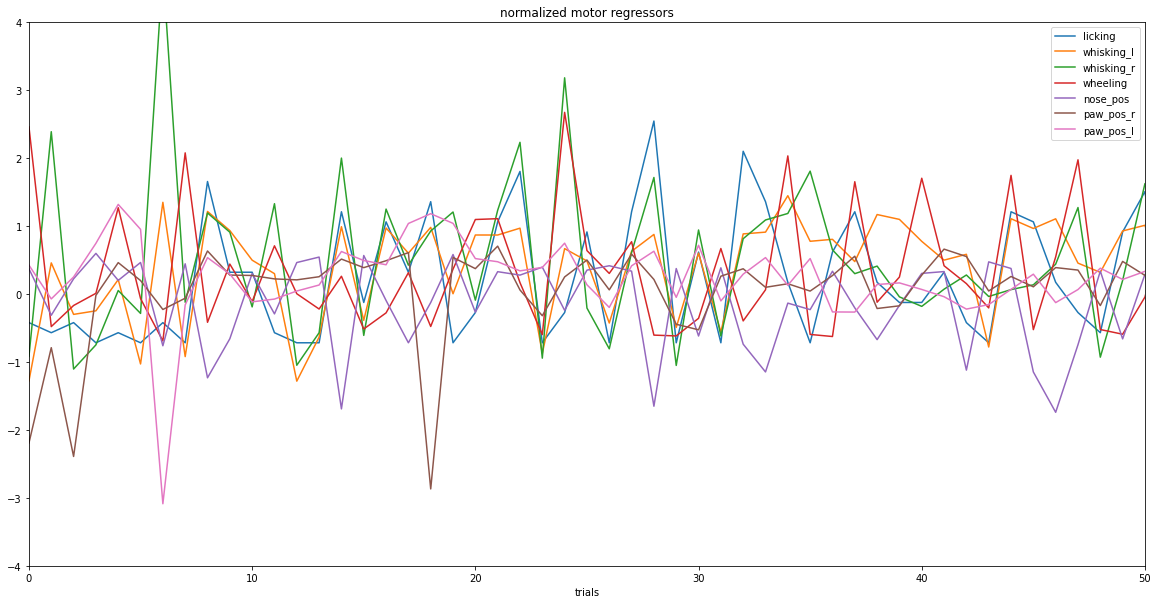

In [31]:
plt.figure(figsize=(20,10))
plt.plot(motor_signals,label=['licking', 'whisking_l', 'whisking_r', 'wheeling', 'nose_pos', 'paw_pos_r', 'paw_pos_l'])
plt.legend()
plt.ylim([-4,4])
plt.xlim([0,50])
plt.xlabel('trials')
plt.title("normalized motor regressors")
plt.show()